### Reference
##### Binary Classification with the UCI Credit-card Default Dataset
##### Mitigating disparities in accuracy as measured by equalized-odds difference

https://github.com/fairlearn/fairlearn/blob/master/notebooks/Binary%20Classification%20with%20the%20UCI%20Credit-card%20Default%20Dataset.ipynb

In [1]:
!pip install fairlearn==0.5.0
!pip install matplotlib
!pip install lightgbm
# brew install libomp

# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds
from fairlearn.widget import FairlearnDashboard

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip


In [2]:
# Load and preprocess the data
df = pd.read_csv("credit_data.txt", delimiter=" ")

prediction_map={1:0, 2:1}
df['PREDICTION'] = df['PREDICTION'].map(prediction_map)

non_num_features = df.select_dtypes(exclude=['number'])
non_num_features = non_num_features.applymap(lambda x: str(x)[-1])
for col in non_num_features:
    df[col] = non_num_features[col].astype('category')
df.head()

/var/folders/g5/d7c143k50b5_gbs7xfgl47900000gn/T/ipykernel_6715/95298064.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_num_features = non_num_features.applymap(lambda x: str(x)[-1])


,STATUS,DURATION,HISTORY,PURPOSE,CREDIT_AMOUNT,SAVINGS_ACCOUNT,PRESENT_EMPLOYMENT,INSTALLMENT_RATE,PERSONAL_STATUS_AND_SEX,OTHER_DEBTORS,...,PROPERTY,AGE,OTHER_INSTALLMENT_PLANS,HOUSING,NUMBER_OF_EXISTING_CREDITS,JOB,NUMBER_OF_PEOPLE_BEING_LIABLE,PHONE,FOREIGN_WORKER,PREDICTION
0,1,6,4,3,1169,5,5,4,3,1,...,1,67,3,2,2,3,1,2,1,0
1,2,48,2,3,5951,1,3,2,2,1,...,1,22,3,2,1,3,1,1,1,1
2,4,12,4,6,2096,1,4,2,3,1,...,1,49,3,2,1,2,2,1,1,0
3,1,42,2,2,7882,1,4,2,3,3,...,2,45,3,3,1,3,2,1,1,0
4,1,24,3,0,4870,1,3,3,3,1,...,4,53,3,3,2,3,2,1,1,1


In [3]:
# To show how to extract and adjust a feature, let's consider "OTHER_INSTALLMENT_PLANS" feature
df['JOB'] = df['JOB'].astype('int32')
A = df['JOB']
A_str = A.map({ 1:"unemployed/ unskilled  - non-resident", 2:"unskilled - resident", 3:"skilled employee / official", 4:"management/ self-employed/ highly qualified employee/ officer"})
# Extract the target feature, which is "PREDICTION" that shows whether a customer is good or bad
Y = df["PREDICTION"]
A_str.head()
# Y.head()

0    skilled employee / official
1    skilled employee / official
2           unskilled - resident
3    skilled employee / official
4    skilled employee / official
Name: JOB, dtype: object

In [4]:
dist_scale = 0.7
np.random.seed(5000)
# Make 'INSTALLMENT_RATE' informative of the target
df['INSTALLMENT_RATE'] = Y + np.random.normal(scale=dist_scale, size=df.shape[0])
# But then make it uninformative for the customers who are unemployed or unskilled.
df.loc[A==1, 'INSTALLMENT_RATE'] = np.random.normal(scale=dist_scale, size=df[A==1].shape[0])
df.loc[A==2, 'INSTALLMENT_RATE'] = np.random.normal(scale=dist_scale, size=df[A==2].shape[0])
df.head()

,STATUS,DURATION,HISTORY,PURPOSE,CREDIT_AMOUNT,SAVINGS_ACCOUNT,PRESENT_EMPLOYMENT,INSTALLMENT_RATE,PERSONAL_STATUS_AND_SEX,OTHER_DEBTORS,...,PROPERTY,AGE,OTHER_INSTALLMENT_PLANS,HOUSING,NUMBER_OF_EXISTING_CREDITS,JOB,NUMBER_OF_PEOPLE_BEING_LIABLE,PHONE,FOREIGN_WORKER,PREDICTION
0,1,6,4,3,1169,5,5,-0.450602,3,1,...,1,67,3,2,2,3,1,2,1,0
1,2,48,2,3,5951,1,3,0.123726,2,1,...,1,22,3,2,1,3,1,1,1,1
2,4,12,4,6,2096,1,4,-0.157364,3,1,...,1,49,3,2,1,2,2,1,1,0
3,1,42,2,2,7882,1,4,0.232007,3,3,...,2,45,3,3,1,3,2,1,1,0
4,1,24,3,0,4870,1,3,1.842735,3,1,...,4,53,3,3,2,3,2,1,1,1


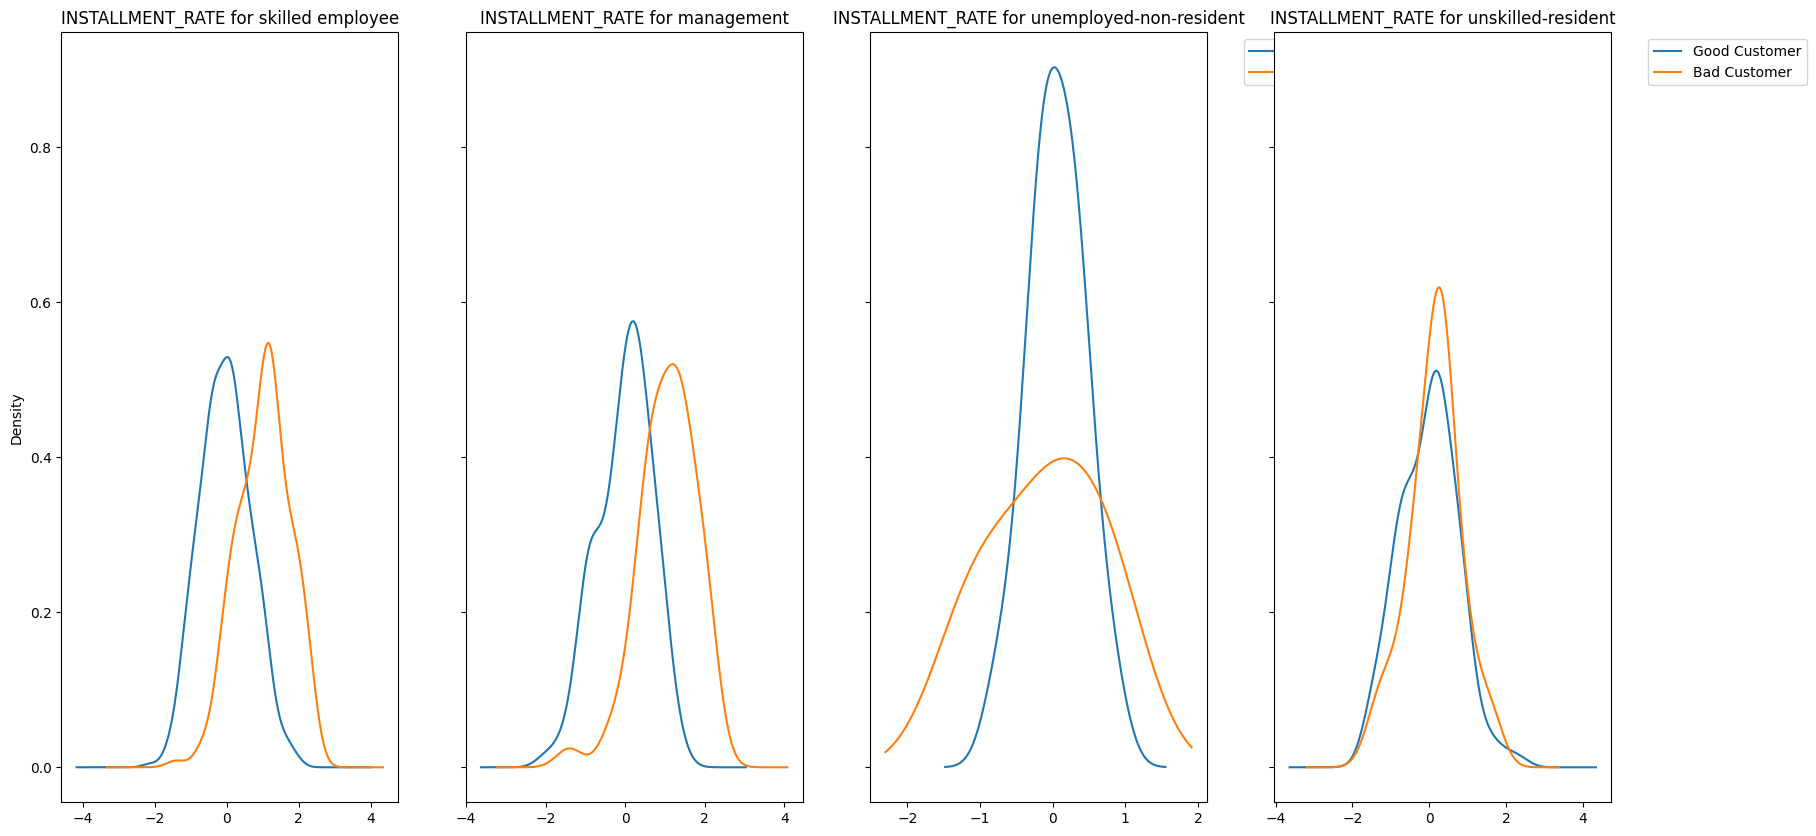

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10), sharey=True)
# Plot distribution of CREDIT_AMOUNT for skilled employee
df['INSTALLMENT_RATE'][(A==3) & (Y==0)].plot(kind='kde', label="Good Customer", ax=ax1,
                                           title="INSTALLMENT_RATE for skilled employee")
df['INSTALLMENT_RATE'][(A==3) & (Y==1)].plot(kind='kde', label="Bad Customer", ax=ax1)
# Plot distribution of CREDIT_AMOUNT for management/ self-employed
df['INSTALLMENT_RATE'][(A==4) & (Y==0)].plot(kind='kde', label="Good Customer", ax=ax2,
                                           title="INSTALLMENT_RATE for management")
df['INSTALLMENT_RATE'][(A==4) & (Y==1)].plot(kind='kde', label="Bad Customer", ax=ax2)
# Plot distribution of LIMIT_BAL for unemployed/ unskilled  - non-resident
df['INSTALLMENT_RATE'][(A==1) & (Y==0)].plot(kind='kde', label="Good Customer", ax=ax3,
                                           legend=True, title="INSTALLMENT_RATE for unemployed-non-resident")
df['INSTALLMENT_RATE'][(A==1) & (Y==1)].plot(kind='kde', label="Bad Customer", ax=ax3,
                                           legend=True).legend(bbox_to_anchor=(1.6, 1))
# Plot distribution of unskilled - resident
df['INSTALLMENT_RATE'][(A==2) & (Y==0)].plot(kind='kde', label="Good Customer", ax=ax4,
                                           legend=True, title="INSTALLMENT_RATE for unskilled-resident")
df['INSTALLMENT_RATE'][(A==2) & (Y==1)].plot(kind='kde', label="Bad Customer", ax=ax4,
                                           legend=True).legend(bbox_to_anchor=(1.6, 1))
plt.show()

Train and test a machine learning model with LightGBM. Then plot the trained models' feature imporantce chart with LGB's `plot_importance` function.

[LightGBM] [Info] Number of positive: 210, number of negative: 490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

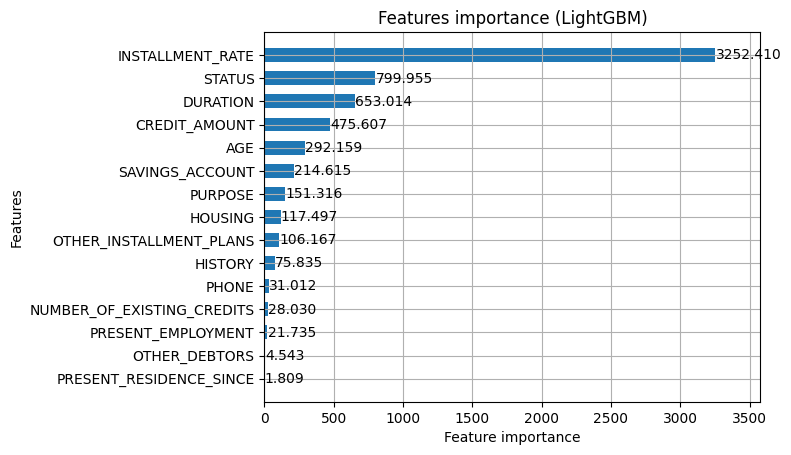

In [6]:
# Train-test split
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    df.drop(columns=['JOB', 'PREDICTION']),
    Y,
    A,
    A_str,
    test_size = 0.3,
    random_state=5000,
    stratify=Y)

lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}

model = lgb.LGBMClassifier(**lgb_params)

model.fit(df_train, Y_train)

# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]

# Train AUC
roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1])

# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

# LightGBM feature importance
lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=21)
plt.show()

In [7]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "-----": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(balanced_accuracy_score, y_true, x, sensitive_features=group).difference(method='between_groups'), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(roc_auc_score, y_true, x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        try:
            if use_preds:
                df_dict[metric_name] = [metric_func(preds) for model_name, (preds, scores) in models_dict.items()]
            else:
                df_dict[metric_name] = [metric_func(scores) for model_name, (preds, scores) in models_dict.items()]
        except Exception as e:
            print(f"Error calculating {metric_name}: {e}")
            df_dict[metric_name] = [None for _ in models_dict.keys()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

    # Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, A_str_test)

Error calculating Demographic parity difference: max() got an unexpected keyword argument 'level'
Error calculating Balanced error rate difference: max() got an unexpected keyword argument 'level'
Error calculating Equalized odds difference: max() got an unexpected keyword argument 'level'
Error calculating AUC difference: max() got an unexpected keyword argument 'level'


,Unmitigated
Overall selection rate,0.413333
Demographic parity difference,None
Demographic parity ratio,0.224138
-----,
Overall balanced error rate,0.231746
Balanced error rate difference,None
Equalized odds difference,None
------,
Overall AUC,0.851323
AUC difference,None


Mitigate the disparities in predictions with the Fairlearn postprocessing algorithm ThresholdOptimizer, use `equalized_odds` for the constraint. (https://fairlearn.github.io/v0.6.0/api_reference/fairlearn.postprocessing.html).

In [8]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds")

# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1000).index)

df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)

models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, A_str_test)

[LightGBM] [Info] Number of positive: 210, number of negative: 210
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 416
[LightGBM] [Info] Number of data points in the train set: 420, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,Unmitigated,ThresholdOptimizer
Overall selection rate,0.413333,0.36
Demographic parity difference,None,None
Demographic parity ratio,0.224138,0.0
-----,,
Overall balanced error rate,0.231746,0.4
Balanced error rate difference,None,None
Equalized odds difference,None,None
------,,
Overall AUC,0.851323,0.6
AUC difference,None,None


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

# Create a pipeline with the scaler and the ThresholdOptimizer
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('postprocess_est', postprocess_est)
])

# Save the pipeline
joblib.dump(pipeline, 'model_pipeline.pkl')

['model_pipeline.pkl']

Umitigated Equalized odds difference: 0.865385	
ThresholdOptimizer algorithm processed equalized odds difference: 0.653846



Compare the disparity in accuracy and prediction between the unmitaged and optimized models with `FairlearnDashboard`.

In [18]:
FairlearnDashboard(sensitive_features=A_str_test, sensitive_feature_names=['JOB'],
                   y_true=Y_test,
                   y_pred={"Unmitigated": test_preds,
                          "ThresholdOptimizer": postprocess_preds})


FairlearnWidget(value={'true_y': [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1…


Disparity in accuracy:
    The umitaged model has a higher level of accuracy of 78%, a lower level of dispararity 
    of 19.7%; while the optimized model has lower accuracy of 74% and higher level of
    dispararity of 26.4%.
    

    
Dispararity in prediction:
    The optimized model has a lower level of accuracy of 74%, but has a lower level of 
    disparity of 13.5%.
    Meanwhile, the unmitaged medel has the highest accuracy of 78%, and the highest disparity
    of 43.3%.
    
    Trade-offs: Even though, in predition, the ThresholdOptimizer algorithm helps the model
    achieves a very high accuracy, in the meantime, it also causes a very high disparity. 
    And in accuracy, it doesn't benift the model. On the contrary, the model without 
    the algorithm performs better.
    

Use `GridSearch`(https://fairlearn.github.io/v0.6.0/api_reference/fairlearn.reductions.html?highlight=gridsearch#fairlearn.reductions.GridSearch)to train multiple models to mitigate the disparities. Create scatter plots to compare the performace (`AUC` or `Balanced Acuracy`) and fairness (`Equalized Odds Difference`) of the `GridSearch`, `ThreshholdOptimizer` and `Unmitigated` models.

In [20]:
import logging
logging.getLogger('fairlearn.reductions').setLevel(logging.ERROR)
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=41,
                   grid_limit=2)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_]
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_]

equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
)
non_dominated = []
for row in all_results.itertuples():
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity]
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max():
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]



TypeError: sum() got an unexpected keyword argument 'level'

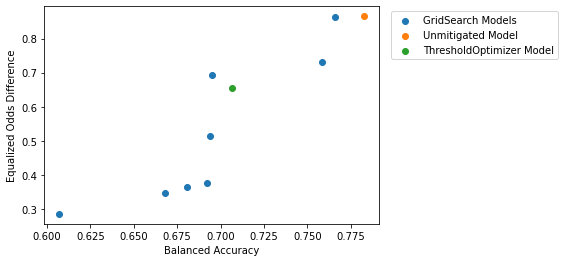

In [ ]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test),
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds),
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

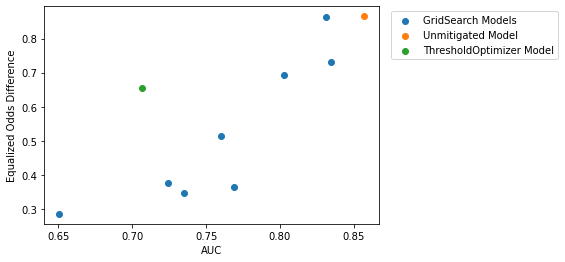

In [21]:
# Plot equalized odds difference vs AUC
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(roc_auc_score(Y_test, test_scores),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test),
            label="Unmitigated Model")
plt.scatter(roc_auc_score(Y_test, postprocess_preds),
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

In [ ]:
model_sweep_dict = {"GridSearch_{}".format(i): sweep_preds[i] for i in range(len(sweep_preds)) if non_dominated[i]}
model_sweep_dict.update({"Unmitigated": test_preds, "ThresholdOptimizer": postprocess_preds})

Use `FairlearnDashboard` to compare the disparity in accuracy and predictions of the trained models.

In [ ]:
FairlearnDashboard(sensitive_features=A_str_test, sensitive_feature_names=['JOB'],
                   y_true=Y_test,
                   y_pred=model_sweep_dict)

NameError: name 'model_sweep_dict' is not defined

Use pycaret to set up the pipeline

My ultimate goal is to find a model with the highest accuracy and the lowest dispararity.
So I would like to choose the GridSearch_6 model. It performs best in accuracy,
with the highest overall accuracy of 80%, and the lowest disparity of 5.46%.